In [1]:
from dependencies import *

Loading dependencies we have already seen...
Importing ray...
Done...


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from mnist_pytorch import get_data_loaders

In [4]:
class ConvNet(nn.Module):
    def __init__(self, width=3):
        super(ConvNet, self).__init__()       
        self.width=width
        
        self.conv1 = nn.Conv2d(1, width, kernel_size=3)
        self.fc = nn.Linear(width*8*8, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.width*8*8)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [5]:
EPOCH_SIZE = 512

def train(model, optimizer, train_loader, device=None):
    device = device or torch.device("cpu")
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [6]:
TEST_SIZE=256

def test(model, data_loader, device=None):
    device = device or torch.device("cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [7]:
print('CUDA Available :D') if torch.cuda.is_available() else print('CPU Only :O')

CUDA Available :D


In [9]:
ray.shutdown()
ray.init(num_cpus=10, num_gpus=1, include_dashboard=True)

2024-10-19 15:52:36,347	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.10.12
Ray version:,2.37.0
Dashboard:,http://127.0.0.1:8266


In [10]:
from os import path

class TrainMNIST(tune.Trainable):
    
    def setup(self, config):
        # detect if cuda is availalbe as ray will assign GPUs if available and configured
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        #
        # In this case this will also fetch the MNIST data on first run
        #
        self.train_loader, self.test_loader = get_data_loaders()
        
        # create the network
        self.model = ConvNet(
            # pass in parameters here if we want to tune network internals
        ).to(self.device)
        
        #setup the optimiser (try Adam instead and change parameters we are tuning)
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=config.get("lr", 0.01),
            momentum=config.get("momentum", 0.9))
                

    def step(self):
        
        train(self.model, self.optimizer, self.train_loader, device=self.device)
        
        acc = test(self.model, self.test_loader, self.device)
        
        return {"mean_accuracy": acc}
    
    
    def save_checkpoint(self, checkpoint_dir):
        # checkpoint_path = path.join(checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), path.join(checkpoint_dir, "model.pth"))
        return checkpoint_dir
    
    
    def load_checkpoint(self, checkpoint_dir):
        checkpoint_path = path.join(checkpoint_dir, "model.pth")
        self.model.load_state_dict(torch.load(checkpoint_path))

In [12]:
config = {
        "lr": tune.uniform(0.001, 0.1),
        "momentum": tune.uniform(0.1, 0.9),
    }


analysis = tune.run(
    TrainMNIST,
    config=config,
    storage_path="/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/statefarm/ray/ray_results/torch_mnist",
    resources_per_trial={
        "cpu": 2,
        "gpu": 0
    },
    num_samples=3,
    checkpoint_at_end=True,
    checkpoint_freq=10,
#     keep_checkpoints_num=3, # only keep n best checkpoints
    stop={
        "mean_accuracy": 0.99,
        "training_iteration": 100,
    })

2024-10-19 16:02:13,140	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-10-19 16:02:13,267	WARNING tune.py:887 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, wrap `train_func` with `tune.with_resources(train_func, resources_per_trial={'gpu': 1})` which allows Tune to expose 1 GPU to each trial. For Ray Train Trainers, you can specify GPU resources through `ScalingConfig(use_gpu=True)`. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,mean_accuracy
TrainMNIST_bd8dd_00000,0.959375
TrainMNIST_bd8dd_00001,0.971875
TrainMNIST_bd8dd_00002,0.921875


(TrainMNIST pid=224200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/statefarm/ray/ray_results/torch_mnist/TrainMNIST_2024-10-19_16-02-13/TrainMNIST_bd8dd_00002_2_lr=0.0678,momentum=0.5517_2024-10-19_16-02-13/checkpoint_000000)
(TrainMNIST pid=224200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/statefarm/ray/ray_results/torch_mnist/TrainMNIST_2024-10-19_16-02-13/TrainMNIST_bd8dd_00002_2_lr=0.0678,momentum=0.5517_2024-10-19_16-02-13/checkpoint_000003) [repeated 9x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(TrainMNIST pid=224200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/sur06423/hiwi/vit_exp/vision_tranformer_ba

In [14]:
from pprint import pprint
print("Best config is:")
pprint(analysis.get_best_trial(metric="mean_accuracy", mode="max"))
pprint(analysis.get_best_config(metric="mean_accuracy", mode="max"))

Best config is:
TrainMNIST_bd8dd_00001
{'lr': 0.01966835346892376, 'momentum': 0.8277595013819906}


In [15]:
train_loader, test_loader = get_data_loaders()

In [16]:
X, y = list(test_loader)[np.random.randint(0, len(test_loader))]

# Find the model checkpoint you want to load

In [22]:
checkpoint_path = path.join(path.expanduser('/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/statefarm/ray'),'ray_results','torch_mnist','TrainMNIST_2024-10-19_16-02-13',
                          'TrainMNIST_bd8dd_00001_1_lr=0.0197,momentum=0.8278_2024-10-19_16-02-13',
                         'checkpoint_000009', 'model.pth')
print(path.exists(checkpoint_path))

True


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.set_grad_enabled(False):
    model = ConvNet()
    model.load_state_dict(torch.load(checkpoint_path))
    
    model.to(device)
    
    y_ = model(X.to(device)).cpu()
    
    _, predicted = torch.max(y_, 1)

/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1704987280714/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


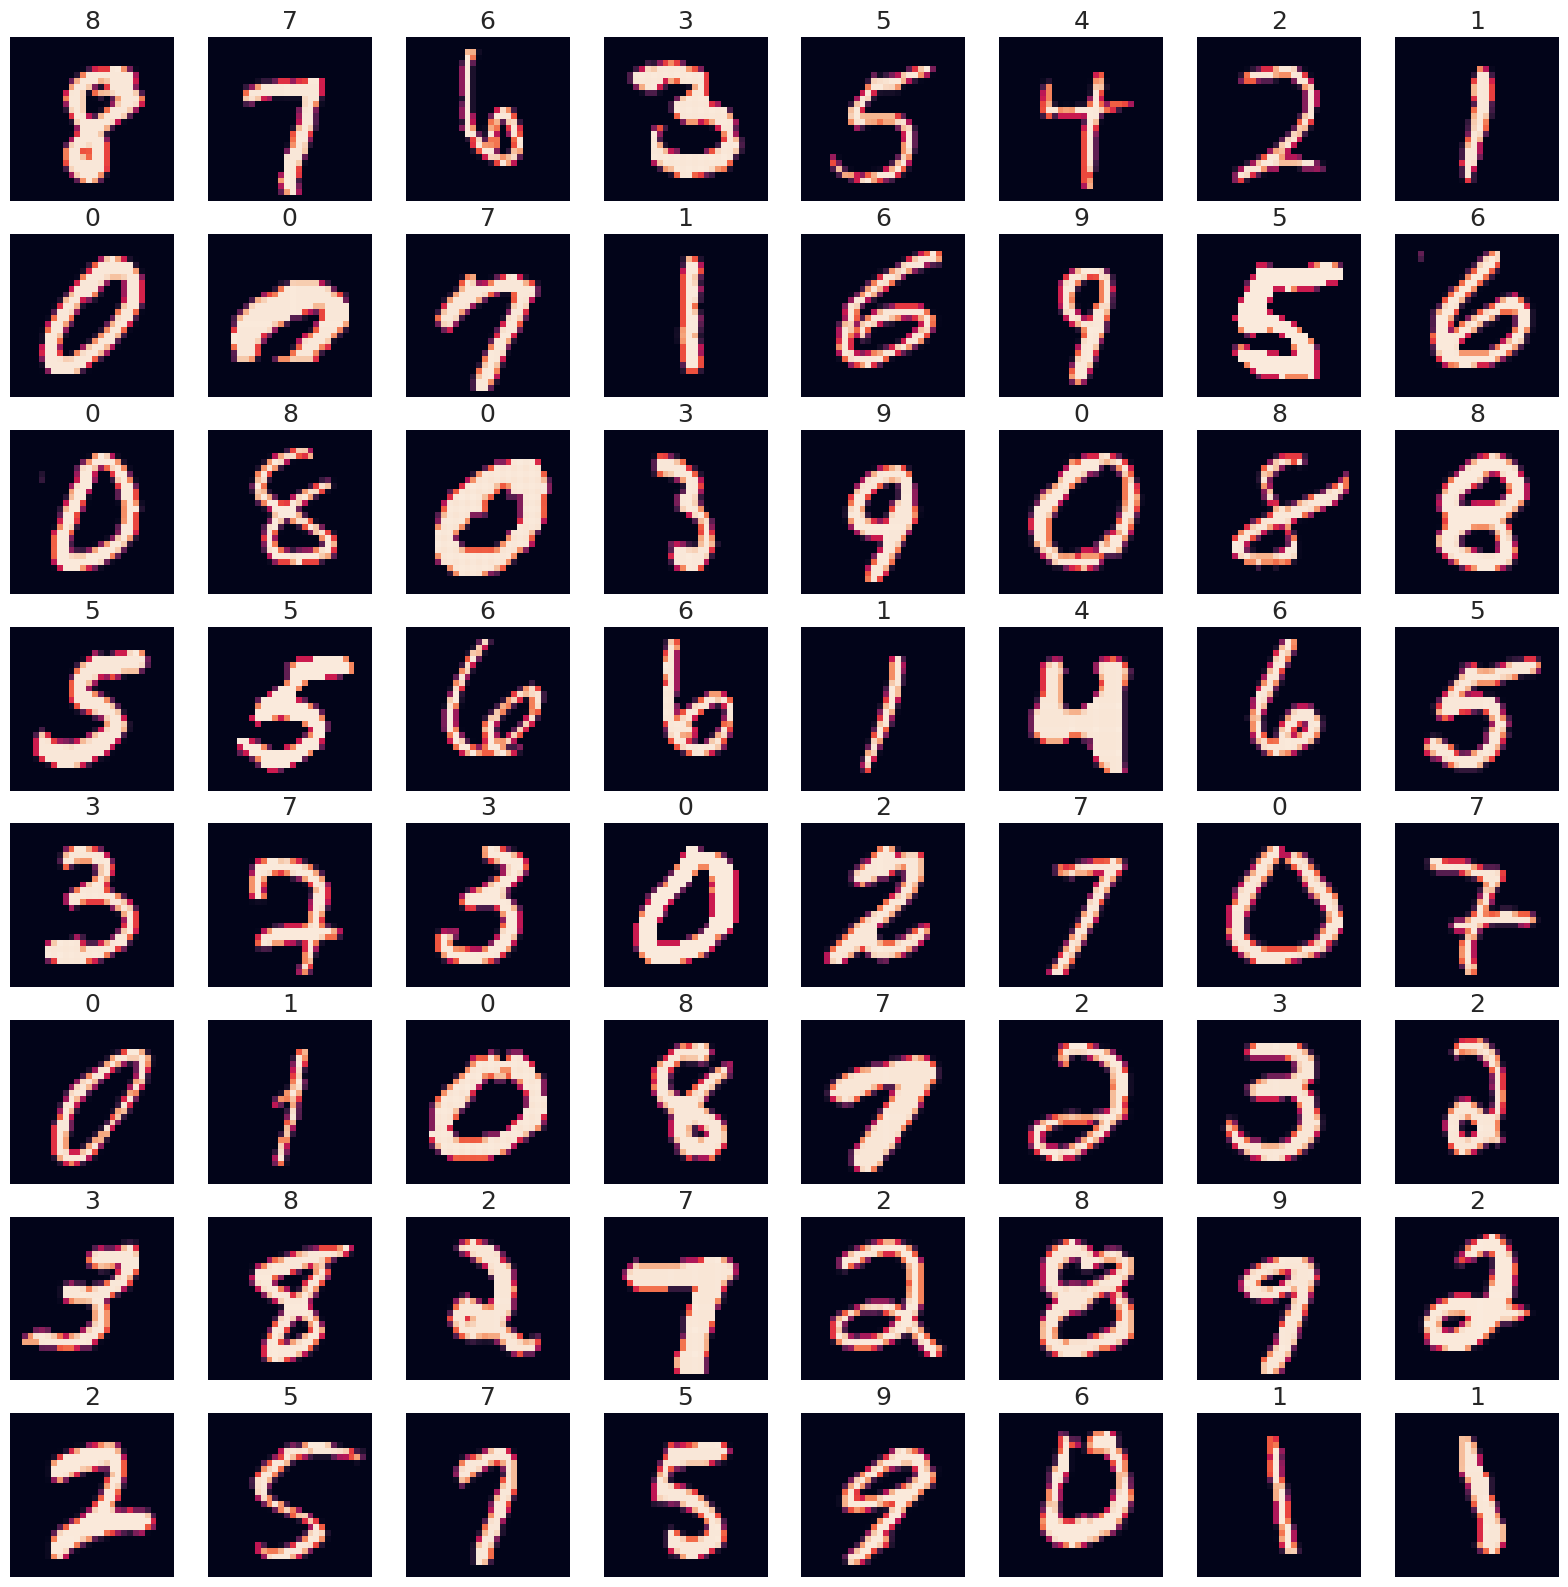

In [24]:
fig, axs = plt.subplots(8,8, figsize=(20,20))
axsf = [item for s in axs for item in s]

for n,ax in enumerate(axsf):
    ax.imshow(X[n].squeeze().numpy())
    ax.axis('off')
    ax.set_title(predicted[n].item())
    
plt.show()

In [25]:
ray.shutdown()